<a href="https://colab.research.google.com/github/Aman2000102/machineLearning/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import shutil
import random
import zipfile

!kaggle datasets download -d anaselmasry/covid19normalpneumonia-ct-images

Dataset URL: https://www.kaggle.com/datasets/anaselmasry/covid19normalpneumonia-ct-images
License(s): copyright-authors
 99% 925M/936M [00:14<00:00, 94.9MB/s]
100% 936M/936M [00:14<00:00, 67.9MB/s]


In [ ]:
# Path to the zip file
path = "covid19normalpneumonia-ct-images.zip"
# Class directories within the zip
classesPath = ['Normal_CT', 'pneumonia_CT']

# Split ratio
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Extract the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Update path to point to the extracted directory
extracted_path = "/content/"

# Create a dictionary to hold the number of files in each class
class_file_counts = {}

# First, gather the number of files in each class to find the minority class
for cls in classesPath:
    src = os.path.join(extracted_path, cls)
    allFileNames = os.listdir(src)
    class_file_counts[cls] = len(allFileNames)

# Find the minimum file count across all classes (the minority class)
min_files = min(class_file_counts.values())

# Ensure the output directories exist
for cls in classesPath:
    os.makedirs(os.path.join('./train/', cls), exist_ok=True)
    os.makedirs(os.path.join('./val/', cls), exist_ok=True)
    os.makedirs(os.path.join('./test/', cls), exist_ok=True)

    # Define the source path for class images
    src = os.path.join(extracted_path, cls)

    # Get list of all image file names in the class directory
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)  # Shuffle the file list to ensure randomness

    # Limit the file count to match the minority class
    balanced_FileNames = allFileNames[:min_files]  # Undersample to match the minority class

    # Calculate the split sizes
    total_files = len(balanced_FileNames)
    train_count = int(train_ratio * total_files)
    val_count = int(val_ratio * total_files)
    test_count = total_files - train_count - val_count  # Remaining files go to the test set

    # Split the filenames into training, validation, and test sets
    train_FileNames = balanced_FileNames[:train_count]
    val_FileNames = balanced_FileNames[train_count:train_count + val_count]
    test_FileNames = balanced_FileNames[train_count + val_count:]

    # Print statistics for each class
    print(f'Total {cls} after balancing: {total_files}')
    print(f'Training: {len(train_FileNames)}')
    print(f'Validation: {len(val_FileNames)}')
    print(f'Testing: {len(test_FileNames)}\n')

    # Copy files to their respective directories
    for name in train_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./train/', cls))

    for name in val_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./val/', cls))

    for name in test_FileNames:
        shutil.copy(os.path.join(src, name), os.path.join('./test/', cls))

Total Normal_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425

Total pneumonia_CT after balancing: 2119
Training: 1271
Validation: 423
Testing: 425



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split  # Import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to directories
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Data Augmentation for Training Set (Preprocessing)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Validation and Test sets should not have augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators for each dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode="rgb",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=90
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode="rgb",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=90
)

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Fetch the entire training dataset from the generator
X_train_full = []
y_train_full = []

for i in range(train_generator.__len__()):
    X_batch, y_batch = train_generator.__getitem__(i)
    X_train_full.append(X_batch)
    y_train_full.append(y_batch)

X_train_full = np.concatenate(X_train_full, axis=0)
y_train_full = np.concatenate(y_train_full, axis=0)

# Split the data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Class weights to handle class imbalance
class_weights_dict = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_dict))

# Initialize DenseNet121 without the top layers (pre-trained on ImageNet)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

# Unfreeze the last few layers of DenseNet for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add GlobalAveragePooling and output layers with Dropout
x = GlobalAveragePooling2D(name="GlobalAveragePooling_1")(base_model.output)
x = Dropout(0.5)(x)  # Add dropout layer to reduce overfitting
y_hat = Dense(1, activation='sigmoid', name="Output")(x)

model_DenseNet = Model(inputs=base_model.input, outputs=y_hat)

# Compile the model with Adam optimizer and Focal Loss
optimizer = Adam(learning_rate=1e-4)  # Use a lower learning rate for fine-tuning
loss = BinaryFocalCrossentropy(gamma=2.0)  # Focal loss to handle class imbalance
model_DenseNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# ModelCheckpoint callback to save the model after training
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model on the training set with validation set
history_DenseNet = model_DenseNet.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights_dict  # Add class weights here
)

# Evaluate on the validation set
val_preds = model_DenseNet.predict(X_val)
val_preds_binary = (val_preds > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_val, val_preds_binary)
precision = precision_score(y_val, val_preds_binary)
recall = recall_score(y_val, val_preds_binary)
f1 = f1_score(y_val, val_preds_binary)

print(f'Validation - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

# Prepare the full test dataset
X_test_full = []
y_test_full = []

for i in range(test_generator.__len__()):
    X_batch, y_batch = test_generator.__getitem__(i)
    X_test_full.append(X_batch)
    y_test_full.append(y_batch)

X_test_full = np.concatenate(X_test_full, axis=0)
y_test_full = np.concatenate(y_test_full, axis=0)

# Predict on the full test set
test_preds = model_DenseNet.predict(X_test_full)
test_preds_binary = (test_preds > 0.5).astype(int)

# Test set metrics on full test set
test_accuracy = accuracy_score(y_test_full, test_preds_binary)
test_precision = precision_score(y_test_full, test_preds_binary)
test_recall = recall_score(y_test_full, test_preds_binary)
test_f1 = f1_score(y_test_full, test_preds_binary)

print(f'Test Set - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}')


Found 2542 images belonging to 2 classes.
Found 850 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.6438 - loss: 0.4124 - val_accuracy: 0.5914 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - accuracy: 0.8908 - loss: 0.1009 - val_accuracy: 0.7583 - val_loss: 0.3501 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9220 - loss: 0.0713 - val_accuracy: 0.8527 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9646 - loss: 0.0308 - val_accuracy: 0.8743 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9733 - loss: 0.0218 - val_accuracy: 0.8232 - val_loss: 0.2462 - learning_rate: 1.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.9734 - loss: 0.020

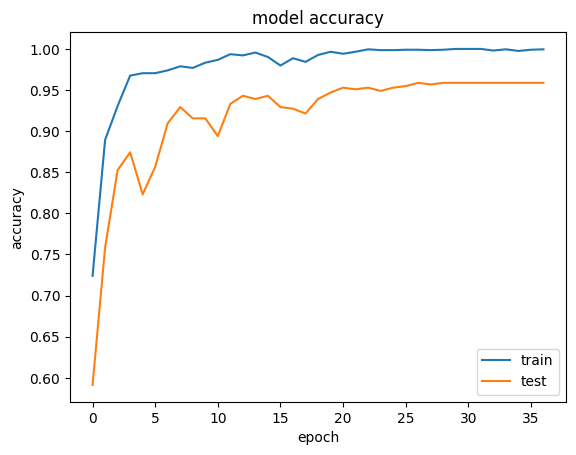

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_DenseNet.history['accuracy'])
plt.plot(history_DenseNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 511ms/step


<Figure size 800x600 with 0 Axes>

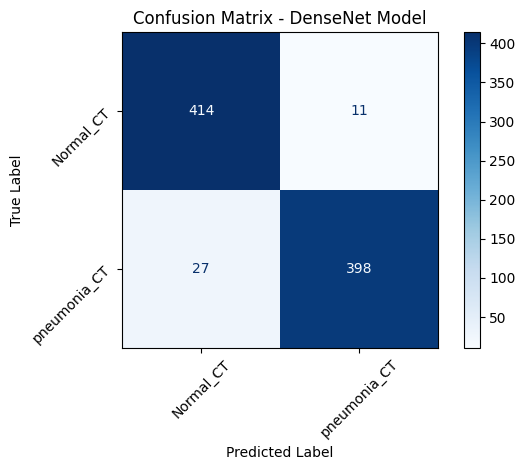

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate model on test data
predictions = model_DenseNet.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).ravel()  # Convert probabilities to class labels (0 or 1)

# True labels
y_true = test_generator.classes  # Assuming test_generator has the true labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - DenseNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_DenseNet.save('/content/drive/MyDrive/Colab Notebooks/DenseNet.h5')

In [ ]:
#Applying XAI techniques on DenseNet model

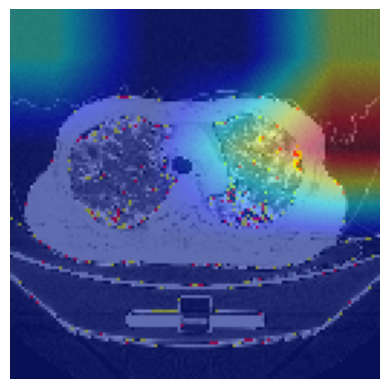

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def apply_grad_cam(image_path, model):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.densenet.preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)

    # Use GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        # Ensure that the last conv layer outputs are being watched for gradients
        last_conv_layer = model.get_layer("conv5_block16_concat")  # Ensure the correct layer name
        iterate = tf.keras.models.Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])
        model_out, last_conv_layer_output = iterate(img_array)

        tape.watch(last_conv_layer_output)  # Watch the layer outputs

        class_out = model_out[:, tf.argmax(model_out[0])]  # Predicted class output
        grads = tape.gradient(class_out, last_conv_layer_output)  # Calculate the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool the gradients

    # Generate heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap)  # Normalize between 0 and 1
    heatmap = heatmap.numpy()

    # Resize the heatmap to match the input image
    heatmap_resized = cv2.resize(heatmap[0], (img_array.shape[2], img_array.shape[1]))

    # Apply colormap on heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert the input image to RGB and uint8
    img_bgr = cv2.cvtColor(np.uint8((img_array[0] + 1) * 127.5), cv2.COLOR_RGB2BGR)  # Undo preprocessing

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap_colored, 0.4, 0)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage with DenseNet model
apply_grad_cam('/content/test/pneumonia_CT/200 (11).jpg', model_DenseNet)


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ecc1e3ea75882a125ba8e11e775532e030bfb0d96e79f9fee1974ca57ede7450
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: [('n02708093', 'analog_clock', 0.17734478), ('n04554684', 'washer', 0.13864347), ('n02974003', 'car_wheel', 0.104560405)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

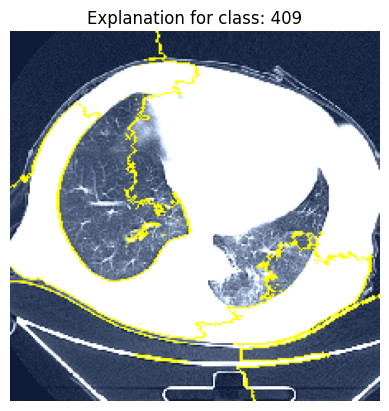

In [ ]:
#Applying LIME XAI technique

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_image_with_lime(model, img_path):
    """
    Explains the prediction of a model on a given image using LIME.

    Parameters:
    - model: A pre-trained model that will be used to make predictions.
    - img_path: The path to the image to be explained.

    Returns:
    - None: The function displays the image with LIME explanations.
    """

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224,224))  # Adjust the target size according to your model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = model.preprocess_input(img_array)  # Replace with your model's preprocess function if needed

    # Get the model's prediction
    preds = model.predict(img_array)
    print('Predicted:', model.decode_predictions(preds, top=3)[0])  # Adjust this according to your model

    # Initialize LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain the prediction
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Get the explanation for the top predicted label
    top_label = np.argmax(preds)
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the image with boundaries
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Explanation for class: {top_label}")
    plt.axis('off')
    plt.show()

# Example usage:
if __name__ == "__main__":
    from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
    model = DenseNet121(weights='imagenet')
    model.preprocess_input = preprocess_input  # Add preprocess and decode functions to the model object
    model.decode_predictions = decode_predictions

    img_path = '/content/test/pneumonia_CT/20 (25).jpg'

     # Call the function to explain the image
    explain_image_with_lime(model, img_path)
